<a href="https://colab.research.google.com/github/gilbertoknd/AI_For_Games/blob/main/Q_learning_Tabular_TaxiV3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tabular Q-learning for Frozen Lake

In this notebook, we will use Q-learning method to solve Frozen Lake.


Environment: (https://gymnasium.farama.org/environments/toy_text/frozen_lake/).

##Setup

In [146]:
%%capture
!pip install gymnasium
!pip install numpy
!pip install imageio imageio_ffmpeg
!pip install pyvirtualdisplay
!apt-get install -y xvfb
!apt-get install -y python-opengl ffmpeg

In [147]:
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

## Setup a Virtual Display
To generate a replay video of agent and environment.

In [148]:
# Virtual display
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [149]:
# Let's start by creating the Frozen Lake environment.
side_map_size = 8
proba_frozen = 0.9

env = gym.make('Taxi-v3', render_mode="rgb_array")
env.spec

EnvSpec(id='Taxi-v3', entry_point='gymnasium.envs.toy_text.taxi:TaxiEnv', reward_threshold=8, nondeterministic=False, max_episode_steps=200, order_enforce=True, disable_env_checker=False, kwargs={'render_mode': 'rgb_array'}, namespace=None, name='Taxi', version=3, additional_wrappers=(), vector_entry_point=None)

##Observing the environment

In [150]:
# actions: move left=0, move down = 1, move right = 2, move up = 3
actions = ["move down", "move up", "move right", "move left", "pickup", "dropoff"]
print ("Actions:", actions)

Actions: ['move down', 'move up', 'move right', 'move left', 'pickup', 'dropoff']


In [151]:
def plot_image(plot, render, size):
  plot.figure(figsize=(14, 5))
  plot.xticks(range(size))
  plot.yticks(range(size))
  plot.imshow(render, extent=[0, size, size, 0])
  plot.show()

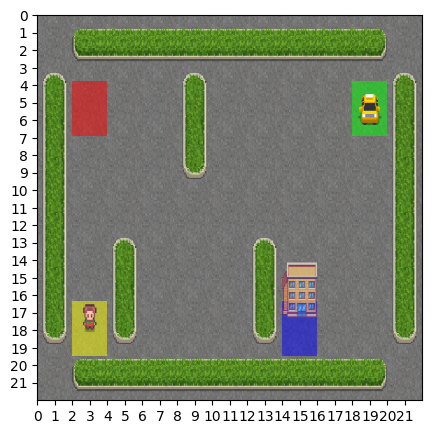

In [152]:
# This sets the initial state at S, our starting point
# We can render the environment to see where we are on the frozenlake gridworld
env.reset()
img = env.render()
plot_image(plt,img,int(np.sqrt(env.observation_space.n)))

##Executing random actions

In [153]:
# Taking a step by selecting a random action[move left=0, move down = 1, move right = 2, move up = 3] from current state
# next_observation: position on the grid
# reward: What rewards did I receive?
# is_terminal: did I end up in the goal state?

print("step number : action, position, reward, terminated, truncated, {info}")

for i in range(20):
    # sample a random action from all valid actions
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    print("step", i+1, ":", action, ",", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
    if(is_terminal):
        break

step number : action, position, reward, terminated, truncated, {info}
step 1 : 1 , move up , 91 , -1 , False , False , {'prob': 1.0, 'action_mask': array([1, 0, 0, 1, 0, 0], dtype=int8)}
step 2 : 0 , move down , 191 , -1 , False , False , {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
step 3 : 0 , move down , 291 , -1 , False , False , {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
step 4 : 4 , pickup , 291 , -10 , False , False , {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
step 5 : 5 , dropoff , 291 , -10 , False , False , {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
step 6 : 0 , move down , 391 , -1 , False , False , {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
step 7 : 2 , move right , 391 , -1 , False , False , {'prob': 1.0, 'action_mask': array([1, 1, 0, 1, 0, 0], dtype=int8)}
step 8 : 4 , pickup , 391 , -10 , False , False , {'prob': 1.0, 'action_mask': array([1, 1, 0, 

In [154]:
from gym.wrappers.monitoring.video_recorder import VideoRecorder
before_training = "before_training.mp4"
video = VideoRecorder(env, before_training)

# returns an initial observation
state, info = env.reset()
env.render()
video.capture_frame()

for i in range(100):
    action = env.action_space.sample()

    state, reward, terminated, truncated, info = env.step(action)
    is_terminal = terminated or truncated

    env.render()
    video.capture_frame()

    if(is_terminal):
        print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
        break

video.close()

/usr/local/lib/python3.12/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [155]:
from base64 import b64encode
def render_mp4(videopath: str) -> str:
  """
  Gets a string containing a b4-encoded version of the MP4 video at the specified path.
  """
  mp4 = open(videopath, 'rb').read()
  base64_encoded_mp4 = b64encode(mp4).decode()
  return f'<video width=400 controls><source src="data:video/mp4;' \
         f'base64,{base64_encoded_mp4}" type="video/mp4"></video>'

In [156]:
from IPython.display import HTML
html = render_mp4(before_training)
HTML(html)

##Building a Q-learning agent

![QL](https://github.com/dudeperf3ct/RL_Notebooks/blob/master/TD/images/ql.png?raw=1)

In [157]:
class FrozenLakeAgent:

    def __init__(
        self,
        alpha_learning_rate: float,
        initial_epsilon: float,
        epsilon_decay: float,
        final_epsilon: float,
        gamma_discount_factor: float,
        state_size: int,
        action_size: int
    ):
        """Initialize a Reinforcement Learning agent with an empty dictionary
        of state-action values (q_table), a learning rate and an epsilon.

        Args:
            alpha_learning_rate: The learning rate
            initial_epsilon: The initial epsilon value
            epsilon_decay: The decay for epsilon
            final_epsilon: The final epsilon value
            gamma_discount_factor: The discount factor for computing the Q-value
            state_size: The state space
            action_size: The action space
        """
        self.alpha_learning_rate = alpha_learning_rate
        self.gamma_discount_factor = gamma_discount_factor
        self.epsilon = initial_epsilon
        self.epsilon_decay = epsilon_decay
        self.final_epsilon = final_epsilon
        self.state_size = state_size
        self.action_size = action_size
        self.training_error = []
        self.q_table = np.zeros((self.state_size, self.action_size))

        # Set the seed
        self.rng = np.random.default_rng(123)

    def get_Q_Table(self):
        return self.q_table

    def eval_state(self, state):
        # Break ties randomly
        # Find the indices where the Q-value equals the maximum value
        # Choose a random action from the indices where the Q-value is maximum
        max_ids = np.where(self.q_table[state, :] == np.max(self.q_table[state, :]))[0]
        return self.rng.choice(max_ids)

    def choose_action(self, state):
        """
        Returns the best action with probability (1 - epsilon)
        otherwise a random action with probability epsilon to ensure exploration.
        """
        # First we randomize a number
        exploration_exploitation_tradeoff = self.rng.uniform(0, 1)

        # Exploration
        # with probability epsilon return a random action to explore the environment
        if exploration_exploitation_tradeoff < self.epsilon:
            return env.action_space.sample()

        # Exploitation (taking the biggest Q-value for this state)
        # with probability (1 - epsilon) act greedily (exploit)
        else:
            return self.eval_state(state)

    def update(
        self,
        state: int,
        action: int,
        reward: float,
        terminated: bool,
        next_state: int,
        next_action: int
    ):
        """Updates the Q-value of an action."""
        if terminated:
            target = reward
        else:
            # Q-learning: Update Q(s,a):= Q(s,a) + alpha [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
            target = reward + self.gamma_discount_factor * np.max(self.q_table[next_state, :])

        temporal_difference_error = target - self.q_table[state, action]

        # Train the agent using target and the predicted q_table values
        self.q_table[state, action] = self.q_table[state, action] + self.alpha_learning_rate * temporal_difference_error

        self.training_error.append(temporal_difference_error)

    def decay_epsilon(self):
        self.epsilon = max(self.final_epsilon, self.epsilon - epsilon_decay)

## Hyperparameters

In [158]:
# hyperparameters
alpha_learning_rate = 0.5 # @param {type:"number"}
nb_max_episodes = 5000 # @param {type:"integer"}
start_epsilon = 0.5 # @param {type:"number"}
final_epsilon = 0.1 # @param {type:"number"}
epsilon_decay = (start_epsilon - final_epsilon) / nb_max_episodes # reduce the exploration over time
gamma_discount_factor = 0.95 # @param {type:"number"}
test_freq = 100 # @param {type:"integer"}
total_steps = 0

agent = FrozenLakeAgent(
    alpha_learning_rate=alpha_learning_rate,
    initial_epsilon=start_epsilon,
    epsilon_decay=epsilon_decay,
    final_epsilon=final_epsilon,
    gamma_discount_factor=gamma_discount_factor,
    state_size = env.observation_space.n,
    action_size = env.action_space.n
)

### Test accurracy

In [159]:
def test_accurracy(num_steps, num_episodes=100):
    counter = 0
    nb_success = 0.0

    while counter < num_episodes:
        is_terminal = False
        state, info = env.reset()

        for i in range(num_steps):
            action = agent.eval_state(state)
            state, reward, terminated, truncated, info = env.step(action)
            is_terminal = terminated or truncated
            nb_success += reward

            if(is_terminal):
                break

        counter += 1

    return nb_success/counter

In [160]:
def record_trained_video(video_file, num_steps):
    video = VideoRecorder(env, video_file)

    # returns an initial observation
    state, info = env.reset()
    env.render()
    video.capture_frame()

    for i in range(num_steps):
        action = agent.eval_state(state)
        state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        env.render()
        video.capture_frame()

        if(is_terminal):
            print("step", i+1, ":", actions[action], ",", state, ",", reward, ",", terminated, ",", truncated, ",", info)
            break

    video.close()

## Playing and Training

In [161]:
from tqdm import tqdm
#Create lists to contain total rewards, steps and accurracy per episode
accuracies = []
mean_rewards = []
rewards = []
steps = []

for episode_count in tqdm(range(nb_max_episodes)):
    state, info = env.reset()
    is_terminal = False
    total_reward = 0
    episode_step = 0

    # The Q-Table training
    while not is_terminal:
        episode_step += 1

        # Choose an action by greedily (with epsilon chance of random action) from the Q-Table
        action = agent.choose_action(state)

        # Play best or random move and get new state and reward from environment
        next_state, reward, terminated, truncated, info = env.step(action)
        is_terminal = terminated or truncated

        # update the agent
        agent.update(state, action, reward, terminated, next_state, None)

        # update the current observation
        state = next_state
        total_steps += 1
        total_reward += reward

    agent.decay_epsilon()

    mean_rewards.append(total_reward)
    if (episode_count+1) % test_freq == 0:
        accur = test_accurracy(env.spec.max_episode_steps,50)
        accuracies.append(accur)

        print('step: %s, episode: %s, accuracy training: %s, accuracy test: %s, random move probability: %s' % (total_steps, episode_count+1, sum(mean_rewards)/test_freq, accur, agent.epsilon))
        mean_rewards.clear()

    rewards.append(total_reward)
    steps.append(episode_step)

after_training = "after_training.mp4"
record_trained_video(after_training, env.spec.max_episode_steps)
env.close()

  2%|▏         | 113/5000 [00:01<01:34, 51.49it/s]

step: 17106, episode: 100, accuracy training: -458.25, accuracy test: -200.0, random move probability: 0.49199999999999755


  5%|▍         | 226/5000 [00:03<01:45, 45.15it/s]

step: 26117, episode: 200, accuracy training: -196.34, accuracy test: -124.06, random move probability: 0.4839999999999951


  7%|▋         | 334/5000 [00:04<00:41, 113.06it/s]

step: 30456, episode: 300, accuracy training: -80.98, accuracy test: -78.44, random move probability: 0.47599999999999265


  9%|▉         | 438/5000 [00:05<00:33, 136.42it/s]

step: 33771, episode: 400, accuracy training: -56.88, accuracy test: -33.34, random move probability: 0.4679999999999902


 11%|█         | 537/5000 [00:05<00:31, 142.47it/s]

step: 36637, episode: 500, accuracy training: -43.03, accuracy test: -16.34, random move probability: 0.45999999999998775


 13%|█▎        | 628/5000 [00:06<00:41, 104.94it/s]

step: 39212, episode: 600, accuracy training: -35.17, accuracy test: -4.8, random move probability: 0.4519999999999853


 15%|█▌        | 769/5000 [00:07<00:22, 184.13it/s]

step: 41814, episode: 700, accuracy training: -35.44, accuracy test: -8.18, random move probability: 0.44399999999998285


 17%|█▋        | 853/5000 [00:07<00:15, 273.83it/s]

step: 44553, episode: 800, accuracy training: -37.8, accuracy test: -0.46, random move probability: 0.4359999999999804


 19%|█▉        | 954/5000 [00:08<00:11, 347.69it/s]

step: 47155, episode: 900, accuracy training: -36.25, accuracy test: 3.26, random move probability: 0.42799999999997795


 22%|██▏       | 1095/5000 [00:08<00:09, 401.50it/s]

step: 49682, episode: 1000, accuracy training: -32.98, accuracy test: 7.66, random move probability: 0.4199999999999755


 24%|██▍       | 1200/5000 [00:08<00:08, 436.71it/s]

step: 52216, episode: 1100, accuracy training: -32.24, accuracy test: 7.54, random move probability: 0.41199999999997305
step: 54580, episode: 1200, accuracy training: -27.93, accuracy test: 7.1, random move probability: 0.4039999999999706


 28%|██▊       | 1403/5000 [00:09<00:06, 588.24it/s]

step: 56974, episode: 1300, accuracy training: -29.22, accuracy test: 7.86, random move probability: 0.39599999999996816
step: 59129, episode: 1400, accuracy training: -21.7, accuracy test: 8.34, random move probability: 0.3879999999999657


 32%|███▏      | 1614/5000 [00:09<00:05, 629.33it/s]

step: 61379, episode: 1500, accuracy training: -23.82, accuracy test: 8.1, random move probability: 0.37999999999996326
step: 63675, episode: 1600, accuracy training: -26.53, accuracy test: 8.36, random move probability: 0.3719999999999608


 36%|███▋      | 1815/5000 [00:09<00:05, 582.78it/s]

step: 65844, episode: 1700, accuracy training: -23.1, accuracy test: 8.04, random move probability: 0.36399999999995836
step: 68046, episode: 1800, accuracy training: -21.36, accuracy test: 7.38, random move probability: 0.3559999999999559


 39%|███▉      | 1970/5000 [00:09<00:04, 638.78it/s]

step: 70136, episode: 1900, accuracy training: -18.8, accuracy test: 8.06, random move probability: 0.34799999999995346
step: 72213, episode: 2000, accuracy training: -19.03, accuracy test: 7.74, random move probability: 0.339999999999951


 44%|████▍     | 2200/5000 [00:10<00:04, 695.33it/s]

step: 74397, episode: 2100, accuracy training: -21.09, accuracy test: 7.86, random move probability: 0.33199999999994856
step: 76490, episode: 2200, accuracy training: -19.55, accuracy test: 7.4, random move probability: 0.3239999999999461


 49%|████▉     | 2440/5000 [00:10<00:03, 705.71it/s]

step: 78527, episode: 2300, accuracy training: -17.91, accuracy test: 7.96, random move probability: 0.31599999999994366
step: 80525, episode: 2400, accuracy training: -16.35, accuracy test: 7.06, random move probability: 0.3079999999999412


 52%|█████▏    | 2600/5000 [00:10<00:03, 678.07it/s]

step: 82408, episode: 2500, accuracy training: -10.25, accuracy test: 8.12, random move probability: 0.29999999999993876
step: 84279, episode: 2600, accuracy training: -13.19, accuracy test: 8.42, random move probability: 0.2919999999999363


 57%|█████▋    | 2843/5000 [00:11<00:02, 743.07it/s]

step: 86174, episode: 2700, accuracy training: -13.34, accuracy test: 8.14, random move probability: 0.28399999999993386
step: 88082, episode: 2800, accuracy training: -11.76, accuracy test: 7.88, random move probability: 0.2759999999999314


 60%|██████    | 3000/5000 [00:11<00:02, 695.17it/s]

step: 89942, episode: 2900, accuracy training: -10.83, accuracy test: 8.18, random move probability: 0.26799999999992896
step: 91803, episode: 3000, accuracy training: -11.11, accuracy test: 8.02, random move probability: 0.2599999999999265


 64%|██████▍   | 3200/5000 [00:11<00:02, 778.61it/s]

step: 93558, episode: 3100, accuracy training: -8.79, accuracy test: 7.86, random move probability: 0.25199999999992406
step: 95358, episode: 3200, accuracy training: -8.52, accuracy test: 8.08, random move probability: 0.24399999999992372


 68%|██████▊   | 3378/5000 [00:11<00:02, 736.90it/s]

step: 97078, episode: 3300, accuracy training: -8.8, accuracy test: 7.72, random move probability: 0.23599999999992405
step: 98843, episode: 3400, accuracy training: -9.16, accuracy test: 7.36, random move probability: 0.22799999999992437


 72%|███████▏  | 3615/5000 [00:12<00:01, 777.90it/s]

step: 100616, episode: 3500, accuracy training: -4.56, accuracy test: 7.74, random move probability: 0.2199999999999247
step: 102276, episode: 3600, accuracy training: -5.05, accuracy test: 8.28, random move probability: 0.21199999999992503


 76%|███████▌  | 3800/5000 [00:12<00:01, 772.19it/s]

step: 104059, episode: 3700, accuracy training: -6.91, accuracy test: 7.8, random move probability: 0.20399999999992535
step: 105733, episode: 3800, accuracy training: -4.02, accuracy test: 8.02, random move probability: 0.19599999999992568


 81%|████████  | 4049/5000 [00:12<00:01, 803.85it/s]

step: 107451, episode: 3900, accuracy training: -5.81, accuracy test: 8.0, random move probability: 0.187999999999926
step: 109042, episode: 4000, accuracy training: -2.83, accuracy test: 7.84, random move probability: 0.17999999999992633


 84%|████████▍ | 4216/5000 [00:12<00:01, 774.23it/s]

step: 110655, episode: 4100, accuracy training: -2.87, accuracy test: 8.4, random move probability: 0.17199999999992666
step: 112279, episode: 4200, accuracy training: -1.81, accuracy test: 8.1, random move probability: 0.16399999999992698


 88%|████████▊ | 4400/5000 [00:13<00:00, 836.26it/s]

step: 113915, episode: 4300, accuracy training: -3.19, accuracy test: 7.74, random move probability: 0.1559999999999273
step: 115481, episode: 4400, accuracy training: 0.12, accuracy test: 8.6, random move probability: 0.14799999999992763


 92%|█████████▏| 4600/5000 [00:13<00:00, 829.06it/s]

step: 117107, episode: 4500, accuracy training: -2.37, accuracy test: 7.88, random move probability: 0.13999999999992796
step: 118637, episode: 4600, accuracy training: 0.48, accuracy test: 8.6, random move probability: 0.13199999999992829


 97%|█████████▋| 4858/5000 [00:13<00:00, 821.98it/s]

step: 120162, episode: 4700, accuracy training: -0.28, accuracy test: 8.66, random move probability: 0.12399999999992861
step: 121639, episode: 4800, accuracy training: 1.37, accuracy test: 7.76, random move probability: 0.11599999999992894


100%|██████████| 5000/5000 [00:13<00:00, 359.08it/s]

step: 123149, episode: 4900, accuracy training: 0.5, accuracy test: 7.98, random move probability: 0.10799999999992926
step: 124636, episode: 5000, accuracy training: 1.9, accuracy test: 8.18, random move probability: 0.1



/usr/local/lib/python3.12/dist-packages/gym/wrappers/monitoring/video_recorder.py:101: DeprecationWarning: WARN: <class 'gym.wrappers.monitoring.video_recorder.VideoRecorder'> is marked as deprecated and will be removed in the future.
  logger.deprecation(
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


step 12 : dropoff , 410 , 20 , True , False , {'prob': 1.0, 'action_mask': array([0, 1, 0, 0, 1, 0], dtype=int8)}


In [162]:
# You should get a video similar to the one below.
html = render_mp4(after_training)
HTML(html)

### Metrics

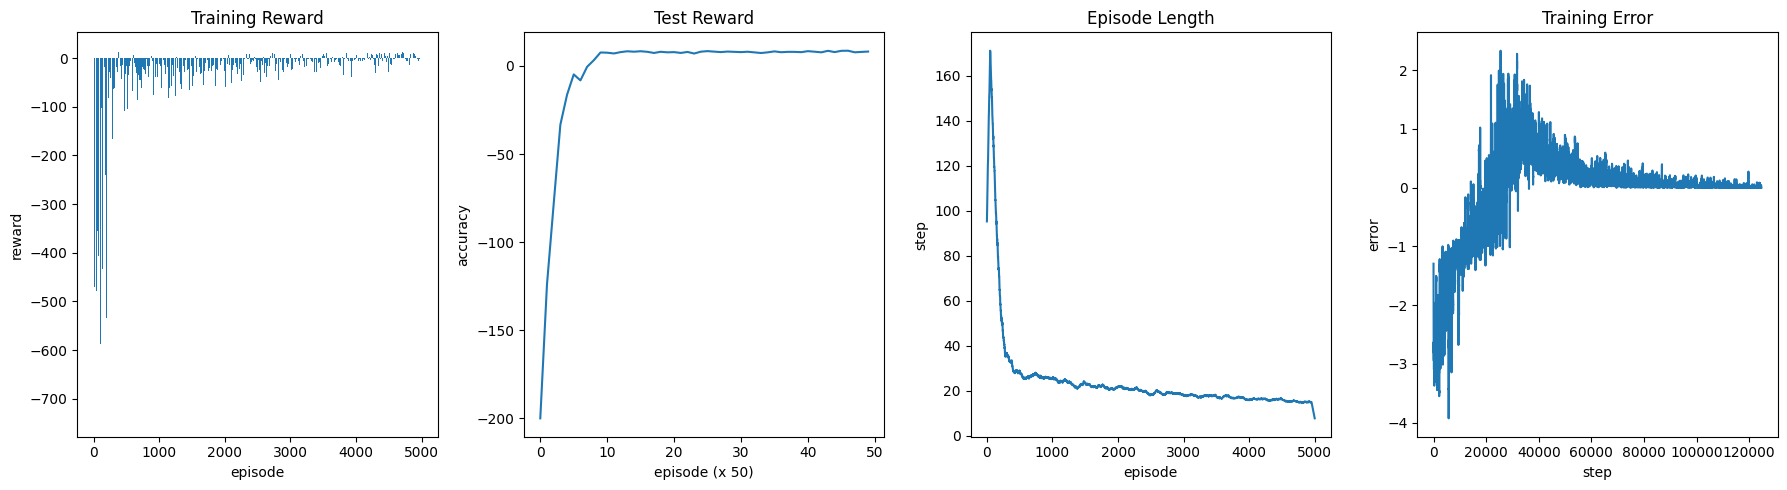

In [163]:
rolling_length = 100
fig, axs = plt.subplots(ncols=4, figsize=(18, 5))
axs[0].set_title("Training Reward")
axs[0].set_xlabel('episode')
axs[0].set_ylabel('reward')
axs[0].bar(range(len(rewards)), rewards)

axs[1].set_title("Test Reward")
axs[1].set_xlabel('episode (x 50)')
axs[1].set_ylabel('accuracy')
axs[1].plot(range(len(accuracies)), accuracies)

axs[2].set_title("Episode Length")
axs[2].set_xlabel('episode')
axs[2].set_ylabel('step')
steps_moving_average = np.convolve(np.array(steps), np.ones(rolling_length), mode="same") / rolling_length
axs[2].plot(range(len(steps_moving_average)), steps_moving_average)

axs[3].set_title("Training Error")
axs[3].set_xlabel('step')
axs[3].set_ylabel('error')
training_error_moving_average = np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same") / rolling_length
axs[3].plot(range(len(training_error_moving_average)), training_error_moving_average)

plt.tight_layout()
plt.show()

In [164]:
def qtable_directions_map(qtable, map_size):
    """Get the best learned action & map it to arrows."""
    qtable_val_max = qtable.max(axis=1).reshape(map_size, map_size)
    qtable_best_action = np.argmax(qtable, axis=1).reshape(map_size, map_size)
    directions = {0: "←", 1: "↓", 2: "→", 3: "↑"}
    qtable_directions = np.empty(qtable_best_action.flatten().shape, dtype=str)
    eps = np.finfo(float).eps  # Minimum float number on the machine
    for idx, val in enumerate(qtable_best_action.flatten()):
        if qtable_val_max.flatten()[idx] > eps:
            # Assign an arrow only if a minimal Q-value has been learned as best action
            # otherwise since 0 is a direction, it also gets mapped on the tiles where
            # it didn't actually learn anything
            qtable_directions[idx] = directions[val]
    qtable_directions = qtable_directions.reshape(map_size, map_size)
    return qtable_val_max, qtable_directions

In [165]:
def plot_q_values_map(qtable, env, map_size):
    """Plot the last frame of the simulation and the policy learned."""
    qtable_val_max, qtable_directions = qtable_directions_map(qtable, map_size)

    # Plot the last frame
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    ax[0].imshow(env.render())
    ax[0].axis("off")
    ax[0].set_title("Last frame")

    # Plot the policy
    sns.heatmap(
        qtable_val_max,
        annot=qtable_directions,
        fmt="",
        ax=ax[1],
        cmap=sns.color_palette("Blues", as_cmap=True),
        linewidths=0.7,
        linecolor="black",
        xticklabels=[],
        yticklabels=[],
        annot_kws={"fontsize": "xx-large"},
    ).set(title="Learned Q-values\nArrows represent best action")
    for _, spine in ax[1].spines.items():
        spine.set_visible(True)
        spine.set_linewidth(0.7)
        spine.set_color("black")
    plt.show()

In [166]:
plot_q_values_map(agent.get_Q_Table(), env, side_map_size)

ValueError: cannot reshape array of size 500 into shape (8,8)